Carregamento e preparação dos dados (Dataset Spotify)

Análise exploratória inicial:
Shape do dataset: (114000, 20)
Gêneros únicos: 114
Distribuição dos gêneros:
track_genre
acoustic       1000
afrobeat       1000
alt-rock       1000
alternative    1000
ambient        1000
anime          1000
black-metal    1000
bluegrass      1000
blues          1000
brazil         1000
Name: count, dtype: int64

Foram removidas 450 linhas duplicadas

Generos da coluna 'track_genre' divididos em super generos:
super_genre
Rock/Metal               20975
Eletrônica               20921
Outros                   18867
Latino/Brasil            12976
Pop                       9983
Mundo/Étnico              9946
Jazz/Blues/Soul/Funk      7992
Clássico/Instrumental     5920
Country/Folk              3979
Hip-Hop/Rap               1991
Name: count, dtype: int64

Features numéricas utilizadas: ['danceability', 'energy', 'valence', 'acousticness', 'speechiness', 'instrumentalness', 'liveness', 'tempo']
Classes id

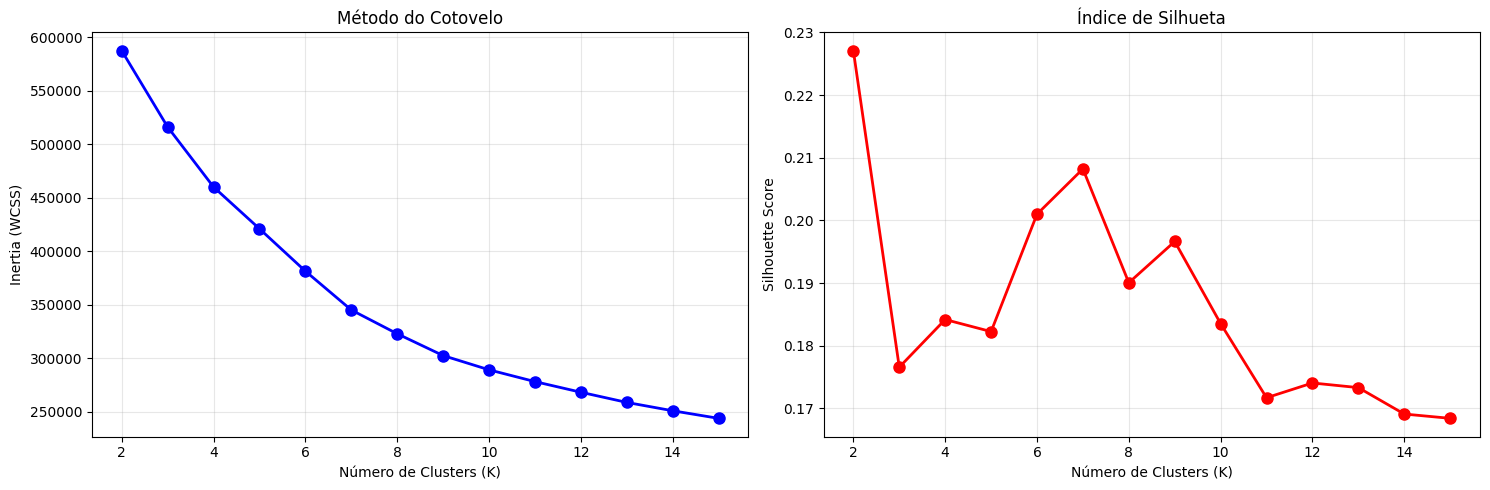


K ótimo baseado no Silhouette Score: 2
K escolhido para análise: 7

Aplicando K-Médias com K=7:
Distribuição dos clusters no treino: [17876  6211 21060  5906 29783  9108   896]


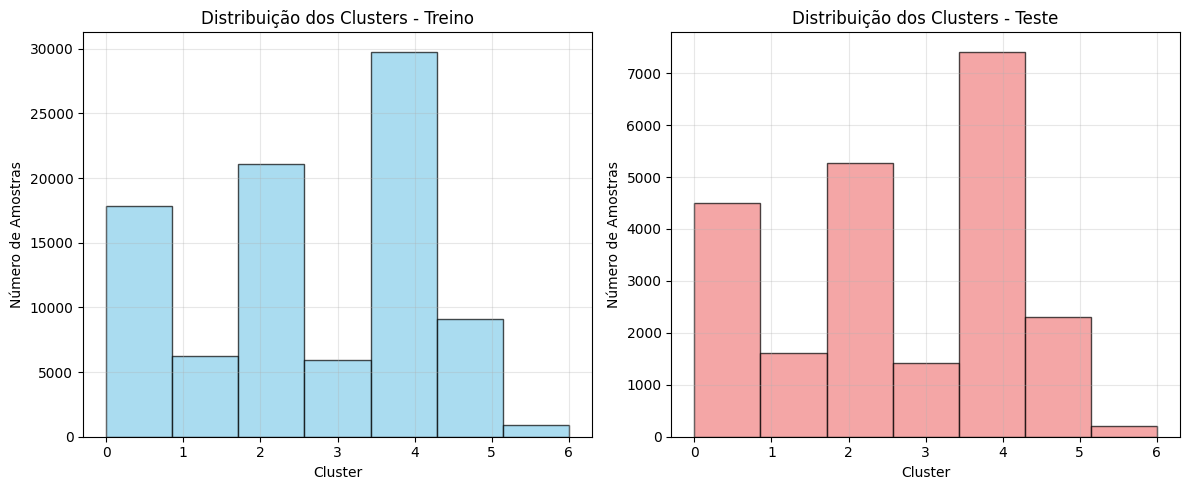


Criação de novas features baseadas nos clusters:
Features originais: 8
Features expandidas: 9
Nova feature: distância ao centroide do cluster mais próximo

Estatísticas das distâncias aos clusters:
Média: 1.840
Desvio padrão: 0.646
Min: 0.287
Max: 6.448

Criação de amostras estratificadas para treino (tamanho 10000):
Tamanho da amostra de treino: 9995 de 90840
Distribuição original: [ 4736  3183 16737  1593  6393 10381  7957 15094  7986 16780]
Distribuição da amostra: [ 521  350 1842  175  703 1142  875 1661  879 1847]

Início do treinamento e avaliação dos modelos de ML..

Treinando modelo SVM com diferentes configurações:

SVM - Features Originais:
Treinando SVM_linear_C1.0 com features Original:
  • Acurácia: 0.360, F1: 0.196, AUC: 0.740
Treinando SVM_linear_C10.0 com features Original:
  • Acurácia: 0.360, F1: 0.196, AUC: 0.737
Treinando SVM_rbf_C1.0 com features Original:
  • Acurácia: 0.403, F1: 0.252, AUC: 0.759
Treinando SVM_rbf_C10.0 com features Original:
  • Acurácia: 0.408

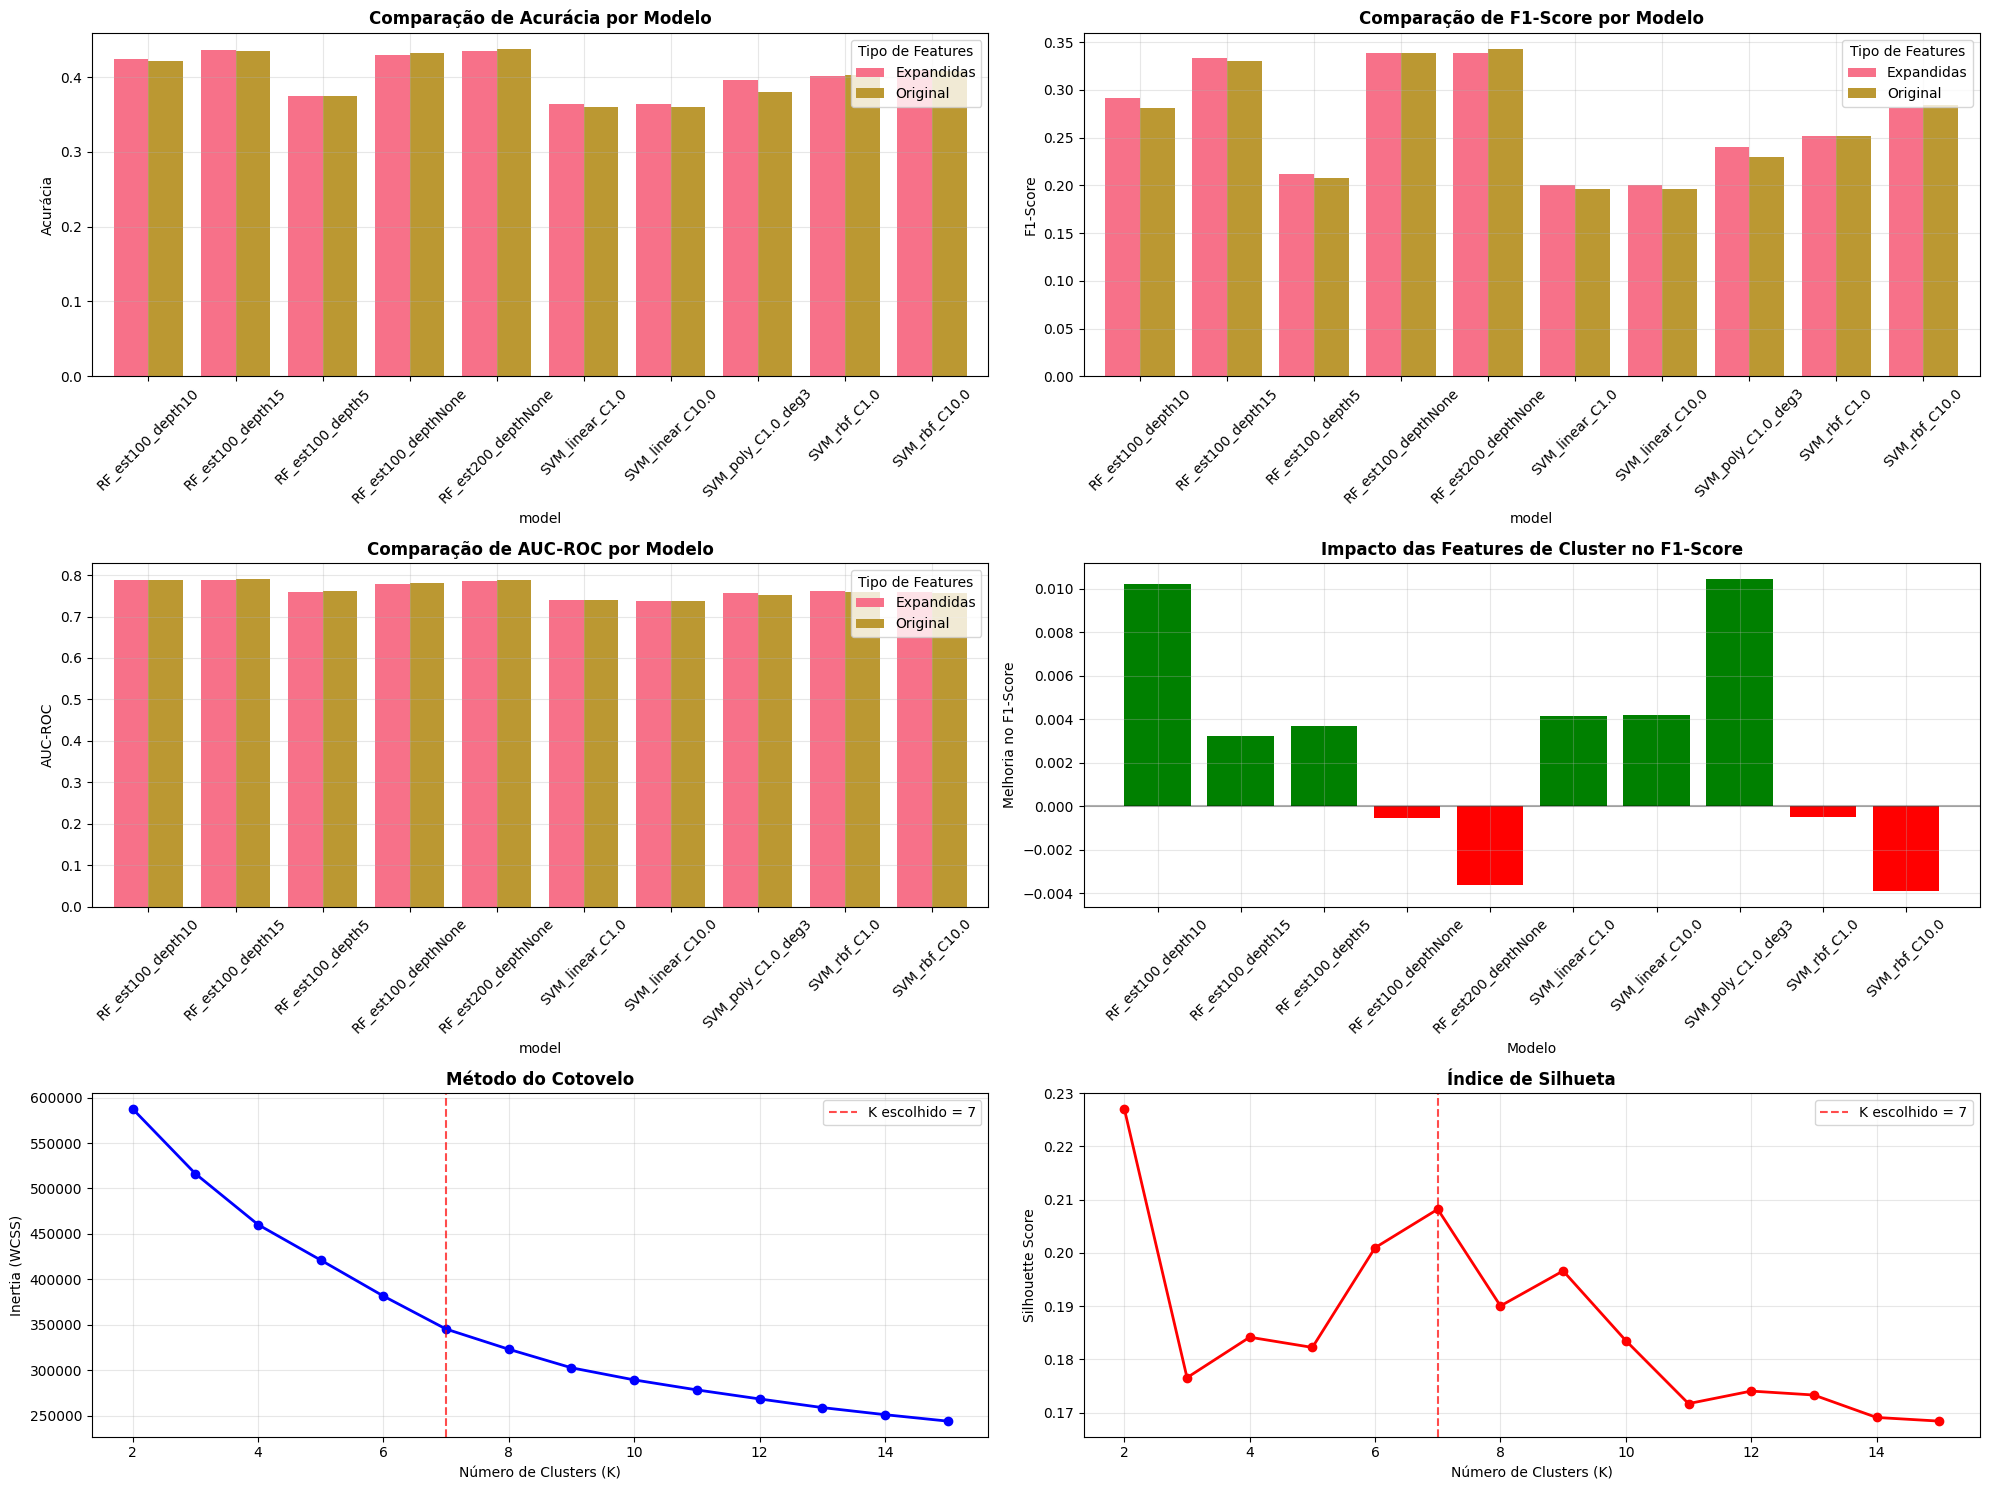


• Análise detalhada dos melhores modelos:

Análise do melhor modelo: RF_est200_depthNone (Original)


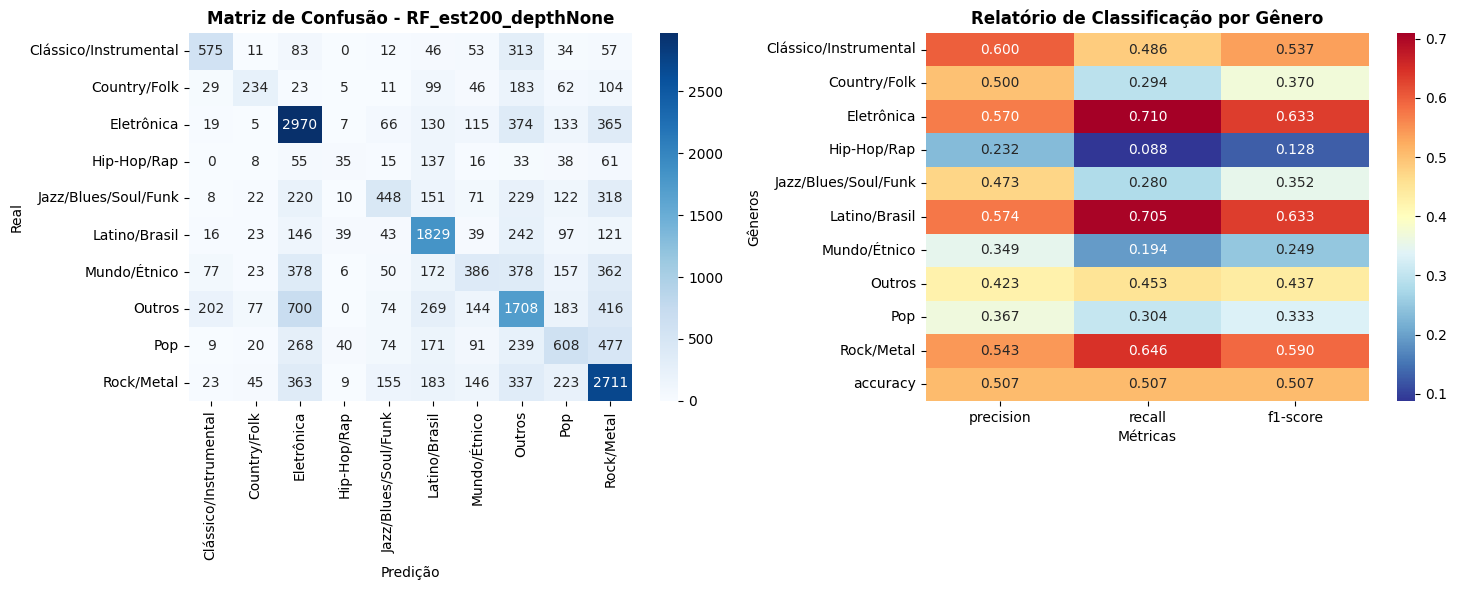


•Resumo dos resultados dos modelos testados:

Resumo dos Melhores Resultados:
Modelo   Features        Configuração Acurácia Precisão Recall F1-Score AUC-ROC
   SVM   Original       SVM_rbf_C10.0    0.408    0.350  0.295    0.284   0.758
   SVM Expandidas       SVM_rbf_C10.0    0.409    0.368  0.293    0.281   0.760
    RF   Original RF_est200_depthNone    0.437    0.390  0.339    0.343   0.788
    RF Expandidas RF_est200_depthNone    0.434    0.381  0.336    0.339   0.785

• Análise de Importância das Features (Random Forest)

Importância da feature 'cluster_distance': 0.096
Ranking da feature de cluster: 8


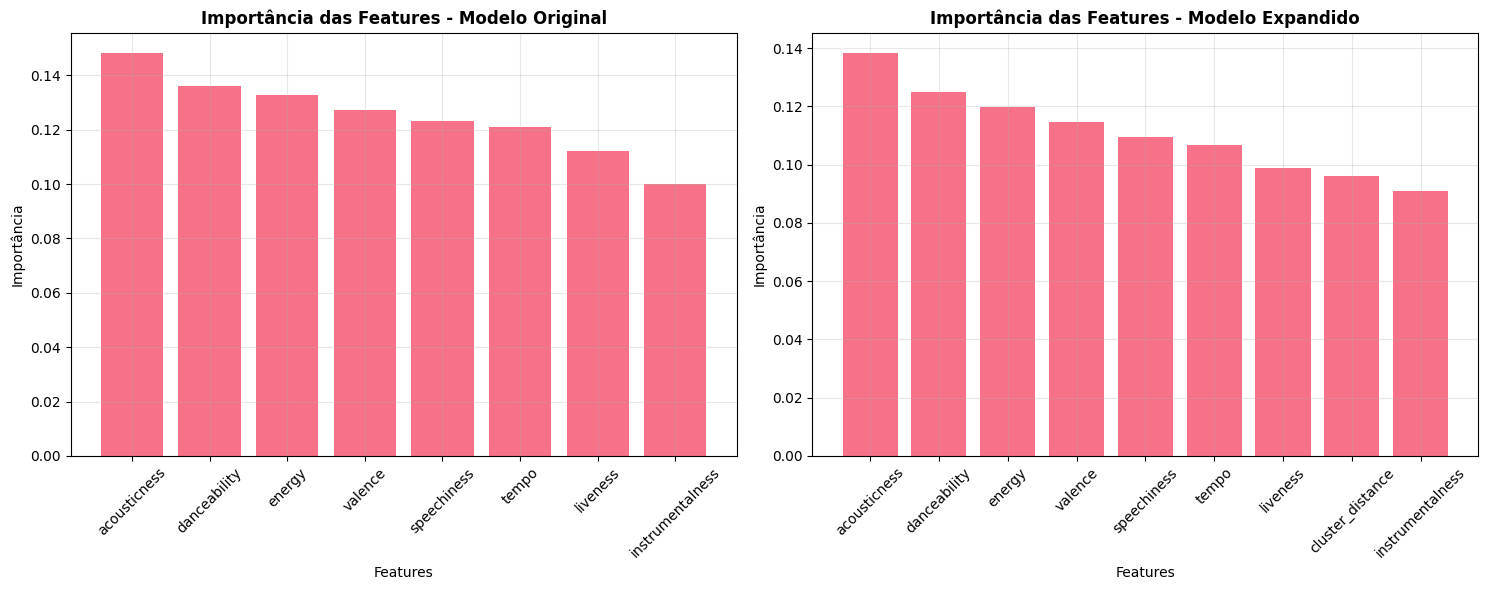


• Análise do impacto das Features de Cluster

Análise de Melhoria com Features de Cluster:
Modelo  F1_Original  F1_Expandido  Melhoria  Melhoria_%
   SVM     0.284416      0.280524 -0.003891   -1.368175
    RF     0.342560      0.338918 -0.003642   -1.063316


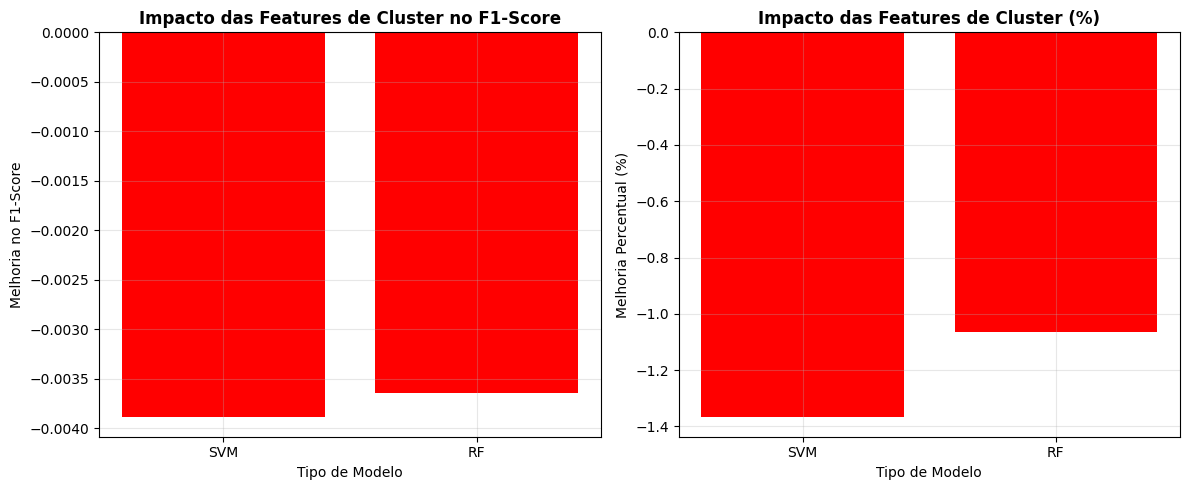


• Análise dos Clusters Formados

Características médias dos clusters:


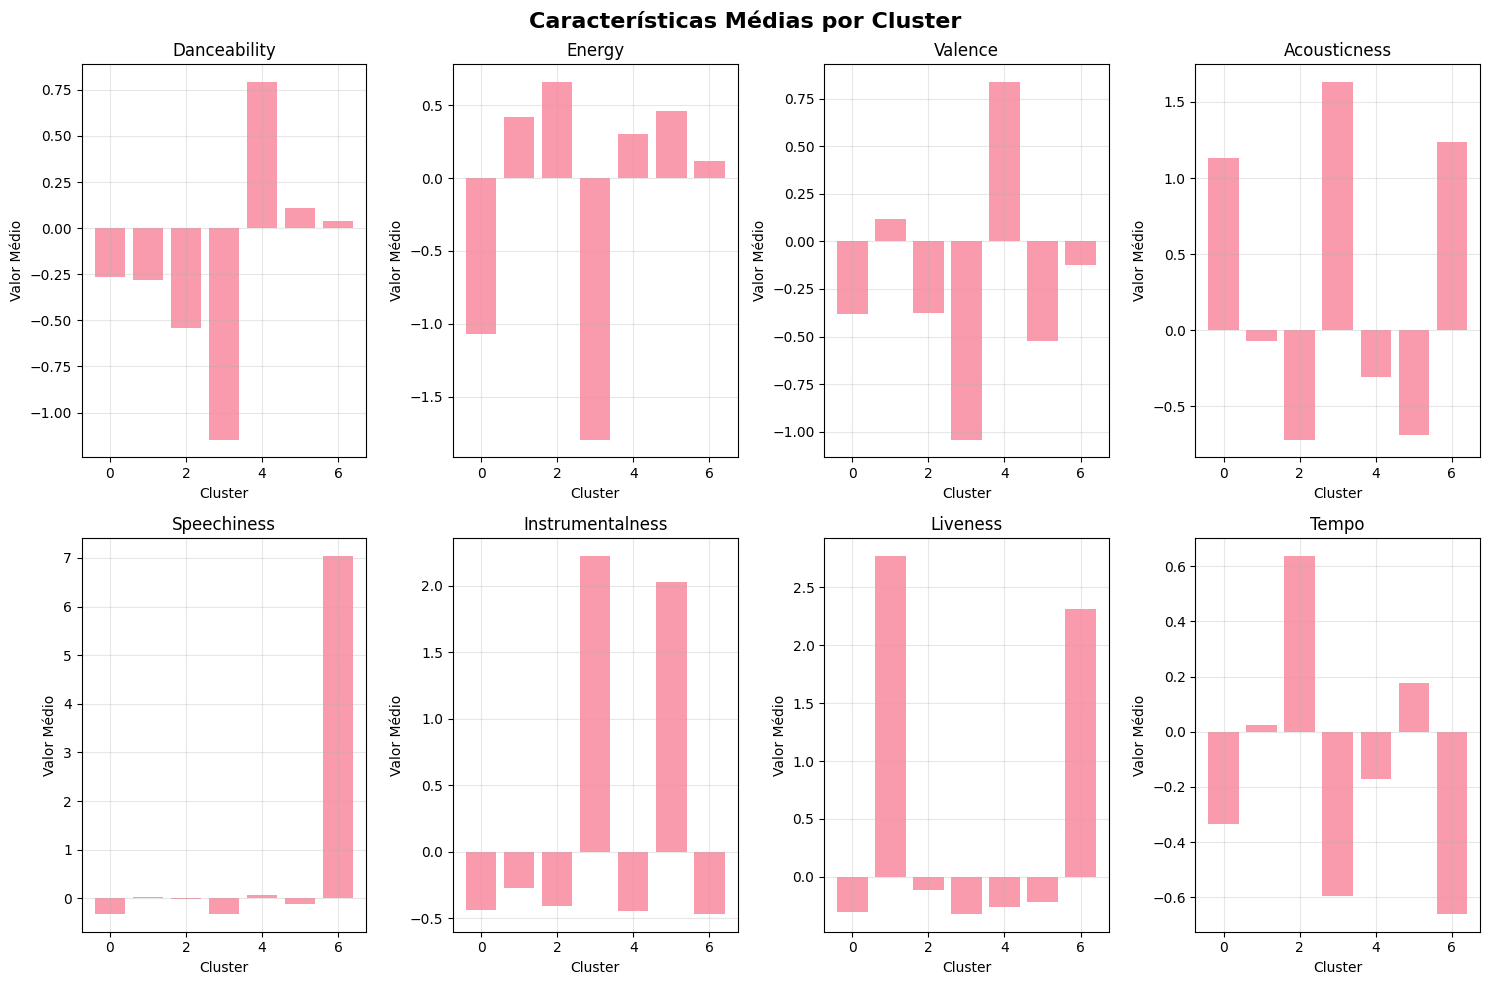

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import cluster, svm, ensemble, preprocessing, model_selection, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

print("Carregamento e preparação dos dados (Dataset Spotify)")

df = pd.read_csv("./data/dataset.csv", index_col=0)

# Análise exploratória inicial
print("\nAnálise exploratória inicial:")
print(f"Shape do dataset: {df.shape}")
print(f"Gêneros únicos: {df['track_genre'].nunique()}")
print(f"Distribuição dos gêneros:")
print(df['track_genre'].value_counts().head(10))

# Remove colunas duplicadas
len_df_before = len(df)
df = df.drop_duplicates()
len_df_after = len(df)

if (len_df_before != len_df_after):
    print(f"\nForam removidas {len_df_before - len_df_after} linhas duplicadas")

# Cria uma nova coluna 'super_genre' baseada em agrupamentos de gêneros
# Para reduzir a complexidade do problema de classificação
# dicionário de agrupamento
genre_map = {
    # Pop
    'pop': 'Pop', 'synth-pop': 'Pop', 'indie-pop': 'Pop', 'k-pop': 'Pop',
    'j-pop': 'Pop', 'pop-film': 'Pop', 'power-pop': 'Pop', 'electro-pop': 'Pop',
    'cantopop': 'Pop', 'mandopop': 'Pop', 'j-idol': 'Pop',

    # Rock / Metal
    'rock': 'Rock/Metal', 'alt-rock': 'Rock/Metal', 'indie': 'Rock/Metal',
    'hard-rock': 'Rock/Metal', 'punk': 'Rock/Metal', 'punk-rock': 'Rock/Metal',
    'psych-rock': 'Rock/Metal', 'heavy-metal': 'Rock/Metal', 'black-metal': 'Rock/Metal',
    'death-metal': 'Rock/Metal', 'metal': 'Rock/Metal', 'metalcore': 'Rock/Metal',
    'grindcore': 'Rock/Metal', 'rock-n-roll': 'Rock/Metal', 'rockabilly': 'Rock/Metal',
    'grunge': 'Rock/Metal', 'goth': 'Rock/Metal', 'emo': 'Rock/Metal',
    'j-rock': 'Rock/Metal', 'industrial': 'Rock/Metal', 'hardcore': 'Rock/Metal',

    # Hip-Hop / R&B
    'hip-hop': 'Hip-Hop/Rap', 'rap': 'Hip-Hop/Rap', 'trap': 'Hip-Hop/Rap',
    'r-n-b': 'Hip-Hop/Rap',

    # Eletrônica / Dance
    'edm': 'Eletrônica', 'electronic': 'Eletrônica', 'dance': 'Eletrônica',
    'house': 'Eletrônica', 'deep-house': 'Eletrônica', 'progressive-house': 'Eletrônica',
    'trance': 'Eletrônica', 'techno': 'Eletrônica', 'minimal-techno': 'Eletrônica',
    'electro': 'Eletrônica', 'club': 'Eletrônica', 'dubstep': 'Eletrônica',
    'drum-and-bass': 'Eletrônica', 'detroit-techno': 'Eletrônica',
    'breakbeat': 'Eletrônica', 'idm': 'Eletrônica', 'j-dance': 'Eletrônica',
    'dancehall': 'Eletrônica', 'garage': 'Eletrônica', 'hardstyle': 'Eletrônica',
    'trip-hop': 'Eletrônica',

    # Jazz / Blues / Soul / Funk
    'jazz': 'Jazz/Blues/Soul/Funk', 'blues': 'Jazz/Blues/Soul/Funk',
    'soul': 'Jazz/Blues/Soul/Funk', 'funk': 'Jazz/Blues/Soul/Funk',
    'groove': 'Jazz/Blues/Soul/Funk', 'ska': 'Jazz/Blues/Soul/Funk',
    'bluegrass': 'Jazz/Blues/Soul/Funk', 'disco': 'Jazz/Blues/Soul/Funk',

    # Latino / Brasil
    'latin': 'Latino/Brasil', 'latino': 'Latino/Brasil', 'samba': 'Latino/Brasil',
    'pagode': 'Latino/Brasil', 'forro': 'Latino/Brasil', 'mpb': 'Latino/Brasil',
    'bossa nova': 'Latino/Brasil', 'brazil': 'Latino/Brasil',
    'salsa': 'Latino/Brasil', 'reggaeton': 'Latino/Brasil',
    'tango': 'Latino/Brasil', 'sertanejo': 'Latino/Brasil',
    'reggae': 'Latino/Brasil', 'afrobeat': 'Latino/Brasil',

    # Country / Folk
    'country': 'Country/Folk', 'honky-tonk': 'Country/Folk',
    'folk': 'Country/Folk', 'guitar': 'Country/Folk',

    # Clássico / Instrumental
    'classical': 'Clássico/Instrumental', 'opera': 'Clássico/Instrumental',
    'piano': 'Clássico/Instrumental', 'instrumental': 'Clássico/Instrumental',
    'study': 'Clássico/Instrumental', 'sleep': 'Clássico/Instrumental',
    'show-tunes': 'Clássico/Instrumental',

    # Mundo / Étnico
    'world-music': 'Mundo/Étnico', 'indian': 'Mundo/Étnico', 'iranian': 'Mundo/Étnico',
    'turkish': 'Mundo/Étnico', 'malay': 'Mundo/Étnico', 'spanish': 'Mundo/Étnico',
    'french': 'Mundo/Étnico', 'swedish': 'Mundo/Étnico', 'german': 'Mundo/Étnico',
    'british': 'Mundo/Étnico',
}

# aplicar o mapeamento na sua coluna
mapped_genres = list(genre_map.keys())
df['super_genre'] = df['track_genre'].apply(
    lambda x: genre_map[x] if x in mapped_genres else 'Outros'
)

# verificar distribuição
print("\nGeneros da coluna 'track_genre' divididos em super generos:")
print(df['super_genre'].value_counts())

# Remove colunas categóricas que não serão usadas
df = df.drop(columns=["track_name", "track_id", "artists", "album_name", "track_genre"])

# Features numéricas selecionadas para análise
features = ['danceability', 'energy', 'valence', 'acousticness', 
           'speechiness', 'instrumentalness', 'liveness', 'tempo']

# Preparação dos dados usados na modelagem
X = df[features]

# Codificação das labels do target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["super_genre"])
genre_names = label_encoder.classes_

print(f"\nFeatures numéricas utilizadas: {features}")
print(f"Classes identificadas: {genre_names}")

# 1) CLUSTERIZAÇÃO COM K-MÉDIAS

print("\nDivisão dos dados em treino e teste (80% treino, 20% teste)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

print("\nNormalização dos dados com StandardScaler:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Média das features de treino após normalização: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Desvio padrão das features de treino após normalização: {np.std(X_train_scaled, axis=0).round(3)}")

print("\nDeterminação do número ótimo de clusters (K) usando K-Médias:")

# Método do Cotovelo (Elbow Method) e Silhouette Score
k_range = range(2, 16)
inertias = []
silhouette_scores = []

print("Calculando métricas para diferentes valores de K:")

# Cria uma amostra de tamanho 20000 para o cálculo da silhueta (mais eficiente)
# Sem a amostra ele fica extremamente lento comprometendo a execução do código
sample_size = min(20000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]

for k in k_range:
    kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Inertia com o conjunto completo de treino
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    
    # Silhouette com a amostra
    labels_sample = kmeans.predict(X_sample)
    silhouette_avg = metrics.silhouette_score(X_sample, labels_sample)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K: {k} => Inertia: {inertias[-1]:.2f}, Silhouette: {silhouette_avg:.3f}")

# Visualização de métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Método do Cotovelo
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Método do Cotovelo')
ax1.grid(True, alpha=0.3)

# Índice de Silhueta
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Índice de Silhueta')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determina o K ótimo
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
# Apesar do K=8 não ser o melhor no Silhouette, é um bom trade-off
# Se analisarmos os dois gráficos, vemos que K=8 é um ponto aproximado de inflexão no cotovelo
# E o segundo maior pico no Silhouette, o que nos traz um bom equilíbrio
best_k = 7

print(f"\nK ótimo baseado no Silhouette Score: {optimal_k_silhouette}")
print(f"K escolhido para análise: {best_k}")

# 4.2 Aplicando K-Médias com o melhor K
print(f"\nAplicando K-Médias com K={best_k}:")
kmeans_best = cluster.KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_train = kmeans_best.fit_predict(X_train_scaled)
clusters_test = kmeans_best.predict(X_test_scaled)

print(f"Distribuição dos clusters no treino: {np.bincount(clusters_train)}")

# Verificar se os clusters estão balanceados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(clusters_train, bins=best_k, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Clusters - Treino')
plt.xlabel('Cluster')
plt.ylabel('Número de Amostras')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(clusters_test, bins=best_k, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribuição dos Clusters - Teste')
plt.xlabel('Cluster')
plt.ylabel('Número de Amostras')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2) CRIAÇÃO DE FEATURES

print("\nCriação de novas features baseadas nos clusters:")

# Função para calcular a distância de cada ponto ao centro do cluster mais próximo
def calculate_cluster_distances(X, kmeans_model):
    distances = []
    for i, point in enumerate(X):
        cluster_label = kmeans_model.predict([point])[0]
        center = kmeans_model.cluster_centers_[cluster_label]
        distance = np.linalg.norm(point - center)
        distances.append(distance)
    return np.array(distances)

# Calculando distâncias para treino e teste
cluster_distances_train = calculate_cluster_distances(X_train_scaled, kmeans_best)
cluster_distances_test = calculate_cluster_distances(X_test_scaled, kmeans_best)

# Criando datasets expandidos
X_train_expanded = np.column_stack([X_train_scaled, cluster_distances_train])
X_test_expanded = np.column_stack([X_test_scaled, cluster_distances_test])

print(f"Features originais: {X_train_scaled.shape[1]}")
print(f"Features expandidas: {X_train_expanded.shape[1]}")
print(f"Nova feature: distância ao centroide do cluster mais próximo")

# Análise das distâncias
print(f"\nEstatísticas das distâncias aos clusters:")
print(f"Média: {np.mean(cluster_distances_train):.3f}")
print(f"Desvio padrão: {np.std(cluster_distances_train):.3f}")
print(f"Min: {np.min(cluster_distances_train):.3f}")
print(f"Max: {np.max(cluster_distances_train):.3f}")

# Criação de amostra estratificada para SVM e Random Forest 
# Isso evita longos tempos de treinamento (SVM) ou uso de memória excessiva (Random Forest)
# Através de amostragem estratificada, garantimos que a proporção das classes
# na amostra seja representativa da distribuição original do dataset.

# Função para criar amostra estratificada,que mantém a proporção das classes
def create_stratified_sample(X, y, sample_size=10000, random_state=42):
    sample_size = min(sample_size, len(X))
    
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    sampled_indices = []

    np.random.seed(random_state)
    
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_proportion = len(class_indices) / total_samples
        class_sample_size = max(1, min(len(class_indices), int(sample_size * class_proportion)))
        
        if len(class_indices) <= class_sample_size:
            sampled_indices.extend(class_indices)
        else:
            class_sample = np.random.choice(class_indices, class_sample_size, replace=False)
            sampled_indices.extend(class_sample)
    
    np.random.shuffle(sampled_indices)
    
    return X[sampled_indices], y[sampled_indices], sampled_indices

# Cria amostras estratificadas de tamanho 10000 para treino
print("\nCriação de amostras estratificadas para treino (tamanho 10000):")
SAMPLE_SIZE = 10000
X_train_sample, y_train_sample, train_sample_indices = create_stratified_sample(
    X_train_scaled, y_train, SAMPLE_SIZE
)

X_train_expanded_sample, _, _ = create_stratified_sample(
    X_train_expanded, y_train, SAMPLE_SIZE, random_state=42
)

print(f"Tamanho da amostra de treino: {len(X_train_sample)} de {len(X_train_scaled)}")
print(f"Distribuição original: {np.bincount(y_train)}")
print(f"Distribuição da amostra: {np.bincount(y_train_sample)}")

print("\nInício do treinamento e avaliação dos modelos de ML..")
# Dicionário para armazenar resultados
results = {
    'model': [],
    'features': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': []
}

# Função para treinar e avaliar modelos (Facilita a avaliação ao final)
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, feature_type):
    print(f"Treinando {model_name} com features {feature_type}:")
    
    # Treinamento
    model.fit(X_train, y_train)

    # Predições
    y_pred = model.predict(X_test)

    # Métricas
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Para AUC-ROC multiclasse
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
        auc_roc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    else:
        auc_roc = accuracy  # Fallback para modelos sem predict_proba
    
    # Armazenando resultados
    results['model'].append(model_name)
    results['features'].append(feature_type)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['auc_roc'].append(auc_roc)
    
    print(f"  • Acurácia: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc_roc:.3f}")
    return model


# 3) MODELOS DE ML (SVM e Random Forest)

# Treina o modelo SVM com diferentes configurações
print("\nTreinando modelo SVM com diferentes configurações:")
svm_configs = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'linear', 'C': 10.0},
    {'kernel': 'rbf', 'C': 1.0},
    {'kernel': 'rbf', 'C': 10.0},
    {'kernel': 'poly', 'C': 1.0, 'degree': 3},
]

# SVM com features originais
print("\nSVM - Features Originais:")
best_svm_original = None
best_svm_original_score = 0

# Treinando e avaliando cada configuração
for config in svm_configs:
    model_name = f"SVM_{config['kernel']}_C{config['C']}"
    if 'degree' in config:
        model_name += f"_deg{config['degree']}"
    
    svc = svm.SVC(**config, probability=True, random_state=42)
    trained_model = evaluate_model(svc, X_train_sample, X_test_scaled, y_train_sample, y_test, 
                  model_name, "Original")
    
    # Guardando o melhor modelo
    current_score = results['f1'][-1]
    if current_score > best_svm_original_score:
        best_svm_original_score = current_score
        best_svm_original = trained_model

# SVM com features expandidas
print("\nSVM - Features Expandidas:")
best_svm_expanded = None
best_svm_expanded_score = 0

for config in svm_configs:
    model_name = f"SVM_{config['kernel']}_C{config['C']}"
    if 'degree' in config:
        model_name += f"_deg{config['degree']}"
    
    svc = svm.SVC(**config, probability=True, random_state=42)
    trained_model = evaluate_model(svc, X_train_expanded_sample, X_test_expanded, y_train_sample, y_test, 
                  model_name, "Expandidas")
    
    # Guardando o melhor modelo
    current_score = results['f1'][-1]
    if current_score > best_svm_expanded_score:
        best_svm_expanded_score = current_score
        best_svm_expanded = trained_model

# Treina o modelo Random Forest com diferentes configurações
print("\nTreinando modelo Random Forest com diferentes configurações:")
rf_configs = [
    {'n_estimators': 100, 'max_depth': None},
    {'n_estimators': 200, 'max_depth': None},
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 15},
]

# Random Forest com features originais
print("\nRandom Forest - Features Originais:")
best_rf_original = None
best_rf_original_score = 0

for config in rf_configs:
    model_name = f"RF_est{config['n_estimators']}_depth{config['max_depth']}"
    rf = ensemble.RandomForestClassifier(**config, random_state=42)
    trained_model = evaluate_model(rf, X_train_sample, X_test_scaled, y_train_sample, y_test, 
                  model_name, "Original")
    
    # Guardando o melhor modelo
    current_score = results['f1'][-1]
    if current_score > best_rf_original_score:
        best_rf_original_score = current_score
        best_rf_original = trained_model

# Random Forest com features expandidas
print("\nRandom Forest - Features Expandidas:")
best_rf_expanded = None
best_rf_expanded_score = 0

for config in rf_configs:
    model_name = f"RF_est{config['n_estimators']}_depth{config['max_depth']}"
    rf = ensemble.RandomForestClassifier(**config, random_state=42)
    trained_model = evaluate_model(rf, X_train_expanded_sample, X_test_expanded, y_train_sample, y_test, 
                  model_name, "Expandidas")
    
    # Guardando o melhor modelo
    current_score = results['f1'][-1]
    if current_score > best_rf_expanded_score:
        best_rf_expanded_score = current_score
        best_rf_expanded = trained_model

# 4) ANÁLISE COMPARATIVA

print("\n• Análise comparativa dos resultados:")
# Converte resultados para DataFrame
results_df = pd.DataFrame(results)

# Encontra os melhores modelos
print("\nMelhores modelos por categoria:")

# Melhor modelo geral
best_overall = results_df.loc[results_df['f1'].idxmax()]
print(f"Melhor modelo geral: {best_overall['model']} ({best_overall['features']})")
print(f"F1-Score: {best_overall['f1']:.3f}")

# Melhor modelo com features originais
best_original = results_df[results_df['features'] == 'Original'].loc[
    results_df[results_df['features'] == 'Original']['f1'].idxmax()
]
print(f"Melhor com features originais: {best_original['model']}")
print(f"F1-Score: {best_original['f1']:.3f}")

# Melhor modelo com features expandidas
best_expanded = results_df[results_df['features'] == 'Expandidas'].loc[
    results_df[results_df['features'] == 'Expandidas']['f1'].idxmax()
]
print(f"Melhor com features expandidas: {best_expanded['model']}")
print(f"F1-Score: {best_expanded['f1']:.3f}")

# Visualizações comparativas
plt.figure(figsize=(20, 15))

# Subplot 1: Comparação de Acurácia
plt.subplot(3, 2, 1)
accuracy_comparison = results_df.groupby(['model', 'features'])['accuracy'].max().reset_index()
accuracy_pivot = accuracy_comparison.pivot(index='model', columns='features', values='accuracy')
accuracy_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de Acurácia por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 2: Comparação de F1-Score
plt.subplot(3, 2, 2)
f1_comparison = results_df.groupby(['model', 'features'])['f1'].max().reset_index()
f1_pivot = f1_comparison.pivot(index='model', columns='features', values='f1')
f1_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de F1-Score por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 3: Comparação de AUC-ROC
plt.subplot(3, 2, 3)
auc_comparison = results_df.groupby(['model', 'features'])['auc_roc'].max().reset_index()
auc_pivot = auc_comparison.pivot(index='model', columns='features', values='auc_roc')
auc_pivot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparação de AUC-ROC por Modelo', fontsize=12, fontweight='bold')
plt.ylabel('AUC-ROC')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Features')
plt.grid(True, alpha=0.3)

# Subplot 4: Impacto das features de cluster
plt.subplot(3, 2, 4)
# Calculando melhoria por modelo
model_groups = results_df.groupby('model')
improvements = []
model_names = []

for model_name, group in model_groups:
    original_scores = group[group['features'] == 'Original']['f1']
    expanded_scores = group[group['features'] == 'Expandidas']['f1']
    
    if len(original_scores) > 0 and len(expanded_scores) > 0:
        improvement = expanded_scores.max() - original_scores.max()
        improvements.append(improvement)
        model_names.append(model_name)

plt.bar(range(len(improvements)), improvements, color=['green' if x > 0 else 'red' for x in improvements])
plt.xlabel('Modelo')
plt.ylabel('Melhoria no F1-Score')
plt.title('Impacto das Features de Cluster no F1-Score', fontsize=12, fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Subplot 5: Método do cotovelo
plt.subplot(3, 2, 5)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Método do Cotovelo', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'K escolhido = {best_k}')
plt.legend()

# Subplot 6: Índice de silhueta
plt.subplot(3, 2, 6)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=6)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Índice de Silhueta', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'K escolhido = {best_k}')
plt.legend()

plt.tight_layout()
plt.show()

# Análise detalhada dos melhores modelos
print("\n• Análise detalhada dos melhores modelos:")

# Matriz de confusão para o melhor modelo
print(f"\nAnálise do melhor modelo: {best_overall['model']} ({best_overall['features']})")

# Retreinando o melhor modelo para análise detalhada
if 'SVM' in best_overall['model']:
    # Extrair configurações do nome do modelo
    parts = best_overall['model'].split('_')
    kernel = parts[1]
    c_value = float(parts[2][1:])  # Remove 'C' do início
    
    config = {'kernel': kernel, 'C': c_value, 'probability': True, 'random_state': 42}
    if 'deg' in best_overall['model']:
        config['degree'] = int(parts[3][3:])  # Remove 'deg' do início
    
    best_model = svm.SVC(**config)
    
    if best_overall['features'] == 'Original':
        best_model.fit(X_train_sample, y_train_sample)
        y_pred_best = best_model.predict(X_test_scaled)
        y_pred_proba_best = best_model.predict_proba(X_test_scaled)
    else:
        best_model.fit(X_train_expanded_sample, y_train_sample)
        y_pred_best = best_model.predict(X_test_expanded)
        y_pred_proba_best = best_model.predict_proba(X_test_expanded)

else:  # Random Forest
    parts = best_overall['model'].split('_')
    n_est = int(parts[1][3:])  # Remove 'est' do início
    max_d = parts[2][5:]  # Remove 'depth' do início
    max_depth = None if max_d == 'None' else int(max_d)
    
    best_model = ensemble.RandomForestClassifier(
        n_estimators=n_est, max_depth=max_depth, random_state=42
    )
    
    if best_overall['features'] == 'Original':
        best_model.fit(X_train_scaled, y_train)
        y_pred_best = best_model.predict(X_test_scaled)
        y_pred_proba_best = best_model.predict_proba(X_test_scaled)
    else:
        best_model.fit(X_train_expanded, y_train)
        y_pred_best = best_model.predict(X_test_expanded)
        y_pred_proba_best = best_model.predict_proba(X_test_expanded)

# Matriz de confusão
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=genre_names, yticklabels=genre_names)
plt.title(f'Matriz de Confusão - {best_overall["model"]}', fontweight='bold')
plt.xlabel('Predição')
plt.ylabel('Real')

# Relatório de classificação
plt.subplot(1, 2, 2)
report = classification_report(y_test, y_pred_best, target_names=genre_names, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :-2].T  # Remove 'accuracy', 'macro avg', 'weighted avg'

# Heatmap do relatório
sns.heatmap(report_df.astype(float), annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Relatório de Classificação por Gênero', fontweight='bold')
plt.xlabel('Métricas')
plt.ylabel('Gêneros')

plt.tight_layout()
plt.show()

# Tabela resumo dos resultados
print("\n•Resumo dos resultados dos modelos testados:")

# Criando tabela resumo com os melhores resultados de cada modelo
summary_results = []

for model_type in results_df['model'].str.split('_').str[0].unique():
    for feature_type in ['Original', 'Expandidas']:
        subset = results_df[
            (results_df['model'].str.contains(model_type)) & 
            (results_df['features'] == feature_type)
        ]
        
        if not subset.empty:
            best_row = subset.loc[subset['f1'].idxmax()]
            summary_results.append({
                'Modelo': model_type,
                'Features': feature_type,
                'Configuração': best_row['model'],
                'Acurácia': f"{best_row['accuracy']:.3f}",
                'Precisão': f"{best_row['precision']:.3f}",
                'Recall': f"{best_row['recall']:.3f}",
                'F1-Score': f"{best_row['f1']:.3f}",
                'AUC-ROC': f"{best_row['auc_roc']:.3f}"
            })

summary_df = pd.DataFrame(summary_results)
print("\nResumo dos Melhores Resultados:")
print(summary_df.to_string(index=False))

# Análise de Importância das Features (Random Forest)
print("\n• Análise de Importância das Features (Random Forest)")

if hasattr(best_rf_original, 'feature_importances_'):
    plt.figure(figsize=(15, 6))
    
    # Features originais
    plt.subplot(1, 2, 1)
    feature_importance_orig = best_rf_original.feature_importances_
    sorted_idx = np.argsort(feature_importance_orig)[::-1]
    
    plt.bar(range(len(features)), feature_importance_orig[sorted_idx])
    plt.title('Importância das Features - Modelo Original', fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Features expandidas
    if hasattr(best_rf_expanded, 'feature_importances_'):
        plt.subplot(1, 2, 2)
        feature_importance_exp = best_rf_expanded.feature_importances_
        feature_names_exp = features + ['cluster_distance']
        sorted_idx_exp = np.argsort(feature_importance_exp)[::-1]
        
        plt.bar(range(len(feature_names_exp)), feature_importance_exp[sorted_idx_exp])
        plt.title('Importância das Features - Modelo Expandido', fontweight='bold')
        plt.xlabel('Features')
        plt.ylabel('Importância')
        plt.xticks(range(len(feature_names_exp)), [feature_names_exp[i] for i in sorted_idx_exp], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Destacando a importância da feature de cluster
        cluster_importance = feature_importance_exp[-1]
        print(f"\nImportância da feature 'cluster_distance': {cluster_importance:.3f}")
        print(f"Ranking da feature de cluster: {sorted_idx_exp.tolist().index(len(feature_names_exp)-1) + 1}")
    
    plt.tight_layout()
    plt.show()

# Análise do impacto das features de cluster
print("\n• Análise do impacto das Features de Cluster")

# Calculando melhorias
improvements_analysis = []

for model_type in ['SVM', 'RF']:
    original_results = results_df[
        (results_df['model'].str.contains(model_type)) & 
        (results_df['features'] == 'Original')
    ]
    expanded_results = results_df[
        (results_df['model'].str.contains(model_type)) & 
        (results_df['features'] == 'Expandidas')
    ]
    
    if not original_results.empty and not expanded_results.empty:
        best_orig = original_results['f1'].max()
        best_exp = expanded_results['f1'].max()
        improvement = best_exp - best_orig
        
        improvements_analysis.append({
            'Modelo': model_type,
            'F1_Original': best_orig,
            'F1_Expandido': best_exp,
            'Melhoria': improvement,
            'Melhoria_%': (improvement / best_orig) * 100
        })

improvement_df = pd.DataFrame(improvements_analysis)
print("\nAnálise de Melhoria com Features de Cluster:")
print(improvement_df.to_string(index=False))

# Visualização do impacto
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_pos = range(len(improvement_df))
plt.bar(x_pos, improvement_df['Melhoria'], 
        color=['green' if x > 0 else 'red' for x in improvement_df['Melhoria']])
plt.title('Impacto das Features de Cluster no F1-Score', fontweight='bold')
plt.xlabel('Tipo de Modelo')
plt.ylabel('Melhoria no F1-Score')
plt.xticks(x_pos, improvement_df['Modelo'])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(x_pos, improvement_df['Melhoria_%'], 
        color=['green' if x > 0 else 'red' for x in improvement_df['Melhoria_%']])
plt.title('Impacto das Features de Cluster (%)', fontweight='bold')
plt.xlabel('Tipo de Modelo')
plt.ylabel('Melhoria Percentual (%)')
plt.xticks(x_pos, improvement_df['Modelo'])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise detalhada dos clusters formados
print("\n• Análise dos Clusters Formados")

# Características dos clusters
cluster_analysis = []
for cluster_id in range(best_k):
    cluster_mask = clusters_train == cluster_id
    cluster_data = X_train_scaled[cluster_mask]
    
    cluster_stats = {
        'Cluster': cluster_id,
        'Tamanho': np.sum(cluster_mask),
        'Danceability': np.mean(cluster_data[:, 0]),
        'Energy': np.mean(cluster_data[:, 1]),
        'Valence': np.mean(cluster_data[:, 2]),
        'Acousticness': np.mean(cluster_data[:, 3]),
        'Speechiness': np.mean(cluster_data[:, 4]),
        'Instrumentalness': np.mean(cluster_data[:, 5]),
        'Liveness': np.mean(cluster_data[:, 6]),
        'Tempo': np.mean(cluster_data[:, 7])
    }
    cluster_analysis.append(cluster_stats)

cluster_df = pd.DataFrame(cluster_analysis)
print("\nCaracterísticas médias dos clusters:")
# Visualização das características dos clusters
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    feature_name = feature.capitalize()
    cluster_means = [cluster_df.iloc[c][feature_name] for c in range(best_k)]
    plt.bar(range(best_k), cluster_means, alpha=0.7)
    plt.title(f'{feature.capitalize()}')
    plt.xlabel('Cluster')
    plt.ylabel('Valor Médio')
    plt.grid(True, alpha=0.3)

plt.suptitle('Características Médias por Cluster', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()